In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

from scipy import signal
from sklearn.manifold import TSNE

import lightgbm as lgb
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('../data/Dataset1.csv')

In [3]:
data.head()

,dateandtime,N,EGT,WF,Status
0,1/4/2018 14:40,90.1169,1372.01,6146.15,0
1,1/4/2018 14:45,90.1253,1369.44,6146.15,0
2,1/4/2018 14:50,90.0491,1366.86,6134.62,0
3,1/4/2018 14:55,90.083,1370.79,6146.15,0
4,1/4/2018 15:00,90.0745,1371.91,6134.62,0


In [4]:
data['Status'].value_counts()

0    4043
2     587
1     139
Name: Status, dtype: int64

In [5]:
data['dateandtime'] = pd.to_datetime(data['dateandtime'])

In [6]:
data = data.dropna()

In [7]:
def deleteEmpty(data, col):
    data = data.reset_index(drop=True)
    ind = []
    for i in range(data.shape[0]):
        a = data[col][i]
        try:
            a = float(a)
        except ValueError:
            ind.append(i)
    data = data.drop(data.index[ind])
    data = data.reset_index(drop=True)
    return data.copy()

In [8]:
def clear(data):
    data = data.dropna()
    print(data.shape)
    data = deleteEmpty(data, 'N')
    print(data.shape)
    data = deleteEmpty(data, 'EGT')
    print(data.shape)
    data = deleteEmpty(data, 'WF')
    print(data.shape)
    
    data['N'] = data['N'].astype('float64')
    data['EGT'] = data['EGT'].astype('float64')
    data['WF'] = data['WF'].astype('float64')
    
    return data.copy()

In [9]:
data = clear(data)

(4761, 5)
(4756, 5)
(4753, 5)
(4750, 5)


In [10]:
data.shape

(4750, 5)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 5 columns):
dateandtime    4750 non-null datetime64[ns]
N              4750 non-null float64
EGT            4750 non-null float64
WF             4750 non-null float64
Status         4750 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 185.6 KB


In [12]:
data.head()

,dateandtime,N,EGT,WF,Status
0,2018-01-04 14:40:00,90.1169,1372.01,6146.15,0
1,2018-01-04 14:45:00,90.1253,1369.44,6146.15,0
2,2018-01-04 14:50:00,90.0491,1366.86,6134.62,0
3,2018-01-04 14:55:00,90.0830,1370.79,6146.15,0
4,2018-01-04 15:00:00,90.0745,1371.91,6134.62,0


In [13]:
def getWhen(time):
    if(time>=0 and time <= 5):
        return 1
    elif(time > 5 and time <= 10):
        return 2
    elif(time > 10 and time <= 17):
        return 3
    elif(time > 17 and time <= 23):
        return 4
    else:
        return 1

In [14]:
def broke_n_days(data, day):
    start = np.max([0, day-3])
    mask = (data['day'] >= start) & (data['day'] < day) & (data['Status'] == 2)
    x = data.loc[mask]
    if(x.shape[0] > 0):
        return 1
    else:
        return 0

In [15]:
def diff_before(data, day, col):
    start = np.max([0, day-3])
    my = data[data['day']==day][col].mean()
    mask = (data['day'] >= start) & (data['day'] < day)
    x = data.loc[mask]
    if(x.shape[0] > 0):
        return x[col].mean() - my
    else:
        return 0

In [16]:
data['day'] = data['dateandtime'].apply(lambda x: x.day)

In [17]:
data['is_even_mor'] = data['dateandtime'].apply(lambda x: getWhen(x.time().hour))

In [18]:
data['broke_3days_before'] = data['dateandtime'].apply(lambda x: 1 if(broke_n_days(data, x.day)) else 0)

In [68]:
#tried to add this features, but they didn't worked

# data['diff_N_before'] = data['dateandtime'].apply(lambda x: diff_before(data, x.day, 'N'))
# data['diff_EGT_before'] = data['dateandtime'].apply(lambda x: diff_before(data, x.day, 'EGT'))
# data['diff_WF_before'] = data['dateandtime'].apply(lambda x: diff_before(data, x.day, 'WF'))

In [20]:
data.head()

,dateandtime,N,EGT,WF,Status,day,is_even_mor,broke_3days_before
0,2018-01-04 14:40:00,90.1169,1372.01,6146.15,0,4,3,1
1,2018-01-04 14:45:00,90.1253,1369.44,6146.15,0,4,3,1
2,2018-01-04 14:50:00,90.0491,1366.86,6134.62,0,4,3,1
3,2018-01-04 14:55:00,90.0830,1370.79,6146.15,0,4,3,1
4,2018-01-04 15:00:00,90.0745,1371.91,6134.62,0,4,3,1


## EGT

In [21]:
data_egt = data[data['EGT'] > 1350]

In [22]:
data_egt.shape

(4621, 8)

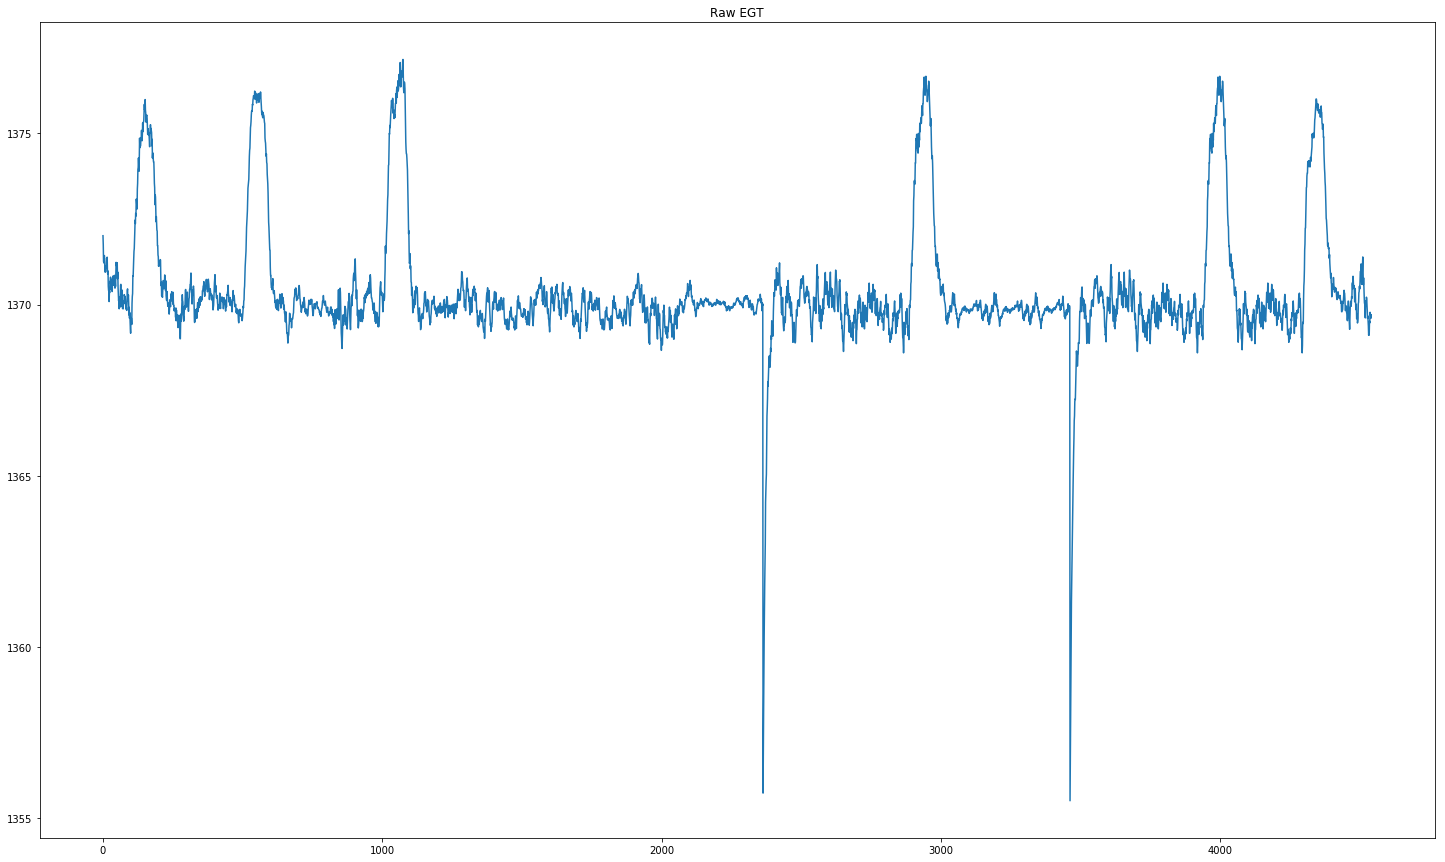

In [64]:
fig = plt.figure(figsize=(25, 15))
plt.plot(range(data_egt['EGT'].shape[0]), data_egt['EGT'])
plt.title('Raw EGT')

In [24]:
# b, a = signal.butter(3, 0.07)
# zi = signal.lfilter_zi(b, a)
# z, _ = signal.lfilter(b, a, data['EGT'], zi=zi*data['EGT'][0])
# z2, _ = signal.lfilter(b, a, z, zi=zi*z[0])

In [25]:
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [26]:
c = np.array(exponential_smoothing(data['EGT'], 0.1))
data['EGT'] = c

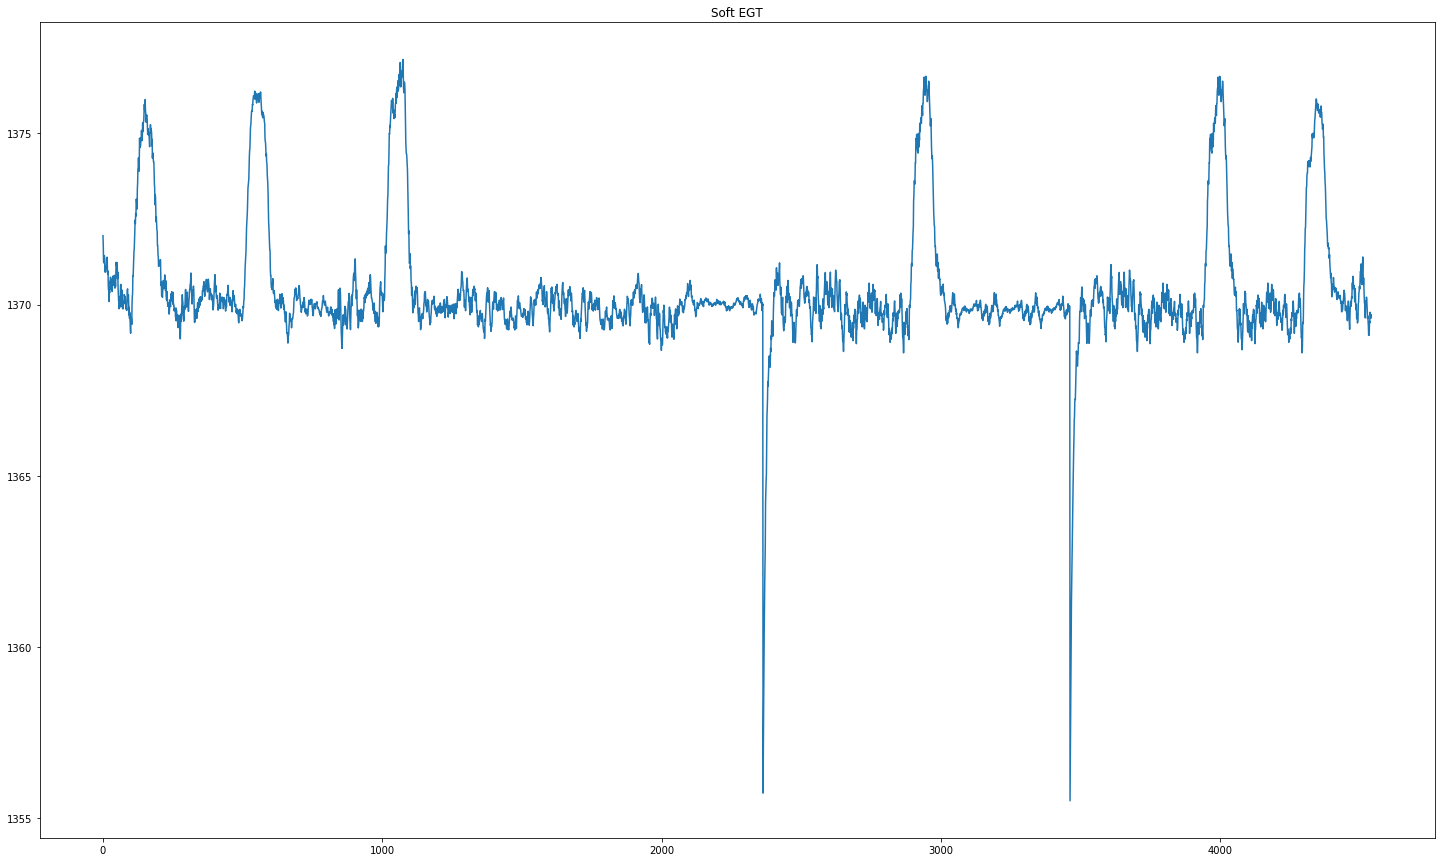

In [63]:
data_egt = data[data['EGT'] > 1355]


fig = plt.figure(figsize=(25, 15))
plt.plot(range(data_egt['EGT'].shape[0]), data_egt['EGT'])
plt.title('Soft EGT')

## Model

In [28]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['dateandtime', 'Status', 'day'], axis=1), 
                                                    data['Status'], test_size=0.3, shuffle=False)

In [29]:
X_train.shape, X_test.shape

((3325, 5), (1425, 5))

In [30]:
X_train.tail()

,N,EGT,WF,is_even_mor,broke_3days_before
3320,92.6067,1369.852586,6373.08,4,1
3321,92.6236,1369.774328,6376.92,4,1
3322,92.6152,1369.856895,6380.77,4,1
3323,92.6745,1369.847205,6376.92,4,1
3324,92.6999,1369.862485,6384.62,4,1


In [32]:
clf = lgb.LGBMClassifier()

In [33]:
%%time
clf.fit(X_train, y_train)

CPU times: user 110 ms, sys: 151 ms, total: 261 ms
Wall time: 201 ms


LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=5, min_split_gain=0, n_estimators=10, nthread=-1,
        num_leaves=31, objective='multiclass', reg_alpha=0, reg_lambda=0,
        seed=0, silent=True, subsample=1, subsample_for_bin=50000,
        subsample_freq=1)

### model performance on train/test

In [34]:
accuracy_score(y_train, clf.predict(X_train)) #train

0.99338345864661659

In [35]:
accuracy_score(y_test, clf.predict(X_test))   #test

0.98736842105263156

In [36]:
f1_score(y_train, clf.predict(X_train), average='macro') #train

0.986488300536153

In [37]:
f1_score(y_test, clf.predict(X_test), average='macro')   #test

0.98031592934088385

In [38]:
print(classification_report(y_train, clf.predict(X_train)))  #train

             precision    recall  f1-score   support

          0       0.99      1.00      1.00      2875
          1       1.00      0.98      0.99        50
          2       0.99      0.96      0.97       400

avg / total       0.99      0.99      0.99      3325



In [39]:
print(classification_report(y_test, clf.predict(X_test)))   #test

             precision    recall  f1-score   support

          0       0.99      0.99      0.99      1149
          1       1.00      0.99      0.99        89
          2       0.96      0.95      0.95       187

avg / total       0.99      0.99      0.99      1425



In [40]:
test_predictions = clf.predict(X_test)

In [42]:
real_status = np.array(y_test)

In [44]:
t = 0
for i in range(real_status.shape[0]):
    if(real_status[i] == 2 and test_predictions[i] == 2):
        t += 1

In [46]:
#number of wrong classified "class - 2" out of 187
print(187 - t)

9

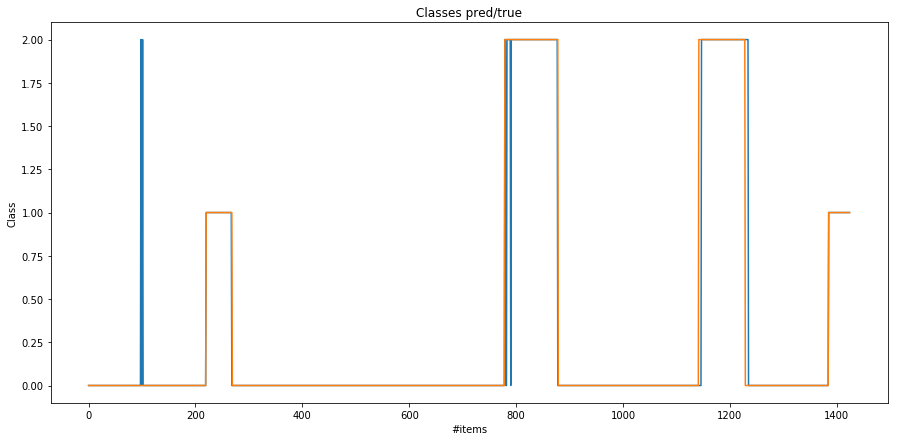

In [67]:
fig = plt.figure(figsize=(15, 7))

plt.plot(range(test_predictions.shape[0]), test_predictions)
plt.plot(range(y_test.shape[0]), y_test)
plt.ylabel('Class')
plt.xlabel('#items')
plt.title('Classes pred/true')

## Clustering

In [48]:
from sklearn.cluster import KMeans

In [49]:
scaler = StandardScaler()

In [50]:
b = data.drop(['dateandtime', 'Status', 'is_even_mor', 'broke_3days_before', 'day'], axis=1)

In [51]:
b.head()

,N,EGT,WF
0,90.1169,1372.010000,6146.15
1,90.1253,1371.753000,6146.15
2,90.0491,1371.263700,6134.62
3,90.0830,1371.216330,6146.15
4,90.0745,1371.285697,6134.62


In [52]:
scaler.fit(b)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [53]:
scaled_b = scaler.transform(b)

In [54]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(scaled_b)

In [55]:
kmeans.labels_

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [56]:
accuracy_score(data['Status'], kmeans.labels_)

0.86989473684210528

## TSNE | "some 2d representation"

In [57]:
%%time
proj = TSNE(n_components=2).fit_transform(scaled_b)

CPU times: user 1min 26s, sys: 11.4 s, total: 1min 38s
Wall time: 1min 39s


In [58]:
def getColor(cl):
    if(cl == 0):
        return 'green'
    elif(cl == 1):
        return 'yellow'
    else:
        return 'red'

In [59]:
colors = [getColor(x) for x in data['Status']]

In [69]:
# green  - active
# yellow - stopped
# red    - damaged

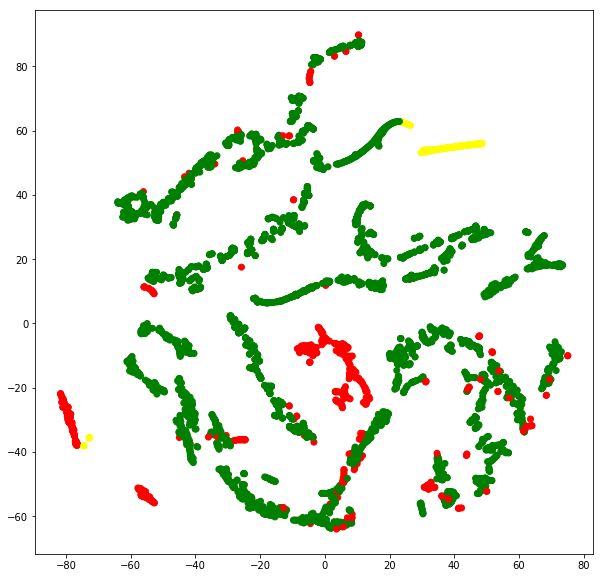

In [60]:
fig = plt.figure(figsize=(10, 10))

plt.scatter(proj[:, 0], proj[:, 1], c=colors)
plt.show()